# Atelier Datacraft - génération de données de synthèse

L'objectif de la partie pratique de cet atelier est axée sur la génération de données sans avoir accès à la base de données réelle. 

**Sommaire**
- [Préparation](#Préparation)
- [1. Limites de la méthode](#1.-Limites-de-la-méthode)
- [2. Axe d'amélioration n°1: réalisme statistique](#2.-Réalisme-statistique)
- [3. Axe d'amélioration n°2: règles métier](#3.-Règles-métier)
- [4. Axe d'amélioration n°3: volumétrie](#4.-Volumétrie)

## Préparation

Dans cette partie, nous installons le module qui sert à générer les données de synthèse. 
<br>Nous récupérons aussi un jeu de données déjà généré.

In [1]:
%load_ext autoreload 
%autoreload 2

In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO

In [ ]:
! git clone https://gitlab.com/healthdatahub/synthetic-generator.git

In [52]:
def url(table,nomenc=False):
    if nomenc: 
        return f'https://gitlab.com/healthdatahub/schema-snds/-/raw/master/nomenclatures/ORAVAL/{table}.csv'
    return f'https://gitlab.com/healthdatahub/formation/exercices-snds/-/raw/hdh_synthetic_data/HDH/data/{table}.csv'

In [22]:
#tables patients
irbenr = pd.read_csv(StringIO(requests.get(url('IR_BEN_R')).text)) #bénéficiaires
mcoc = pd.read_csv(StringIO(requests.get(url('T_MCOaaC')).text)) #chaînage 
mcob = pd.read_csv(StringIO(requests.get(url('T_MCOaaB')).text)) #contient les résumés de séjours et diagnostics
mcod = pd.read_csv(StringIO(requests.get(url('T_MCOaaD')).text)) #contient les diagnostics associés
mcoa = pd.read_csv(StringIO(requests.get(url('T_MCOaaA')).text)) #contient les actes

In [60]:
#nomenclatures
ircimv = pd.read_csv(StringIO(requests.get(url('IR_CIM_V',nomenc=True)).text),sep=';') #nomenclature des diagnostics
cim2lib = ircimv[['CIM_COD','CIM_LIB']].set_index('CIM_COD').to_dict()['CIM_LIB']

**La structure de jointure est comme suit:**
<br>IR_BEN_R $\rightarrow$ T_MCOaaC sur `BEN_NIR_PSA`|`NIR_ANO_17`
<br>T_MCOaaC $\rightarrow$ T_MCOaaB sur `['ETA_NUM','RSA_NUM']`
<br>T_MCOaaB $\rightarrow$ T_MCOaaD sur `['ETA_NUM','RSA_NUM']`
<br>T_MCOaaB $\rightarrow$ T_MCOaaA sur `['ETA_NUM','RSA_NUM']`

## 1. Limites de la méthode

Dans cette partie, nous exposons différentes limites de la méthode de génération. Cela nous permet aussi de nous familiariser avec le jeu de données. 

*Le jeu de données est une portion du Système National des Données de Santé (SNDS).
L'extrait donné ici est constitué de données d'hospitalisation.* 

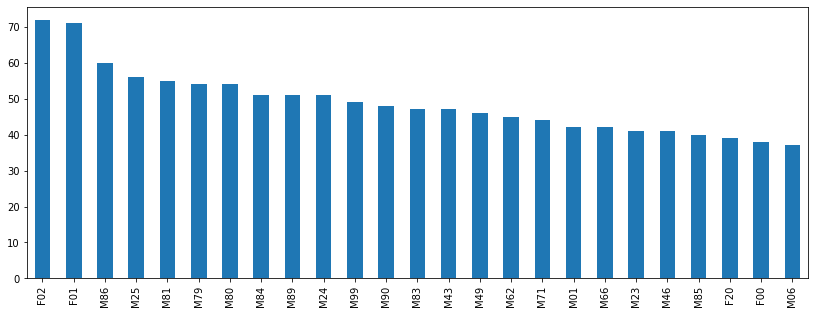

In [56]:
# distribution des diagnostics
plt.figure(figsize=(14,5))
mcob['DGN_PAL'].apply(lambda x:x[:3])\
               .value_counts()\
               .sort_values(ascending=False)\
               .iloc[:25]\
               .plot(kind='bar')
plt.show()

In [61]:
#diagnostic le plus fréquent
cim2lib['F02']

"Démence au cours d'autres maladies classées ailleurs"

In [55]:
flat_mco = mcob[['DGN_PAL','ETA_NUM','RSA_NUM']]\
            .merge(mcoc[['NIR_ANO_17','ETA_NUM','RSA_NUM']],on=['RSA_NUM','ETA_NUM'])\
            .merge(irbenr[['BEN_NAI_ANN','BEN_NIR_PSA','BEN_SEX_COD']],
                    left_on='NIR_ANO_17',
                    right_on='BEN_NIR_PSA')

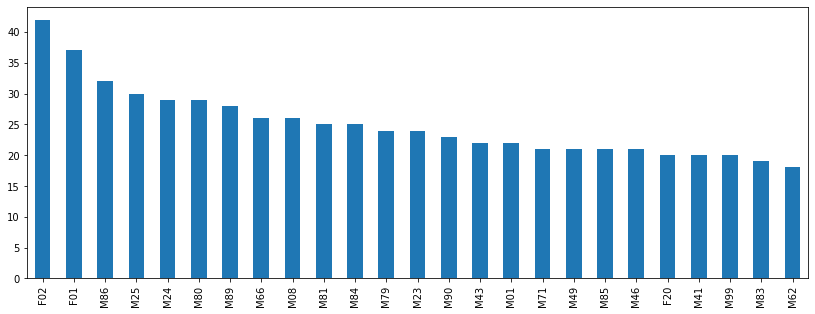

In [65]:
#problèmes liés à l'âge
plt.figure(figsize=(14,5))
#filtrage sur les patients de moins de 30 ans
flat_mco[flat_mco['BEN_NAI_ANN']>=1990]\
['DGN_PAL']\
.apply(lambda x:x[:3])\
.value_counts()\
.sort_values(ascending=False)\
.iloc[:25]\
.plot(kind='bar')
plt.show()

On voit le même diagnostic apparaître comme diagnostic le plus fréquent (or il est peu probable que la démence soit le diagnostic le plus fréquent chez les patients de moins de 30 ans)

In [75]:
# corrélation nombre d'hospitalisations / âge

n_hosp = flat_mco.groupby('BEN_NIR_PSA')\
                 .count()['ETA_NUM']\
                 .reset_index()\
                 .rename(columns={'ETA_NUM':'n_hosp'})\
                 .merge(irbenr,on='BEN_NIR_PSA')
n_hosp

,BEN_NIR_PSA,n_hosp,BEN_RNG_GEM,BEN_NIR_ANO,BEN_IDT_ANO,BEN_IDT_TOP,ASS_NIR_ANO,BEN_IDT_MAJ,BEN_CDI_NIR,BEN_NAI_ANN,...,BEN_DCD_DTE,BEN_DCD_AME,ORG_AFF_BEN,BEN_RES_DPT,BEN_RES_COM,BEN_TOP_CNS,MAX_TRT_DTD,ORG_CLE_NEW,BEN_DTE_INS,BEN_DTE_MAJ
0,AArNMWoOCccownnLL,6,1,lPFncTYdmUvppwNKj,hLLNzJzCEjCatjuOQ,True,bQILbCWSdkGtOFVRV,29Mar2008:16:06:58,09,2009,...,27SEP1944:00:00:00,201605,01C741986,012,5,True,23/03/1977,01C141031,18AUG1946:00:00:00,29DEC1879:00:00:00
1,AAraajBBOvYaZiPjo,3,0,mwbazBsxNuOwBZaBD,SOtppObsuLTTswJvn,False,WVLsDaagYickHVstY,18May1977:10:26:53,05,2004,...,11JUN2007:00:00:00,201709,01C631231,012,18,False,11/07/1975,99C191599,28MAR2016:00:00:00,15AUG1966:00:00:00
2,AEucNQUlsOsucxkKG,2,0,FCEHHgXopcjjVOhvo,ZQWdkNGowBqQazPvh,False,BIimmcssWLqkAbwjb,13Mar1985:18:30:46,NN,1971,...,10DEC1943:00:00:00,201112,01M311537,065,157,True,25/03/2000,91C541493,07APR1975:00:00:00,31OCT1934:00:00:00
3,AFEsSBefRtfZVjOTS,9,5,OYtDssffadniPtRNH,ppBEgPUTdlboxdtZe,True,gbIchBantEbcUYIii,08Dec1972:01:50:10,99,1972,...,15JUL2007:00:00:00,198508,95C331005,065,480,True,30/06/2007,92C511052,10JUN1882:00:00:00,04JAN1912:00:00:00
4,AGVklNcRTyLgcjSNf,1,4,dYEugVIEFFsqGckzP,oiwKBXKSCAQduiLeu,False,lkqMQwmlIAhLSAyyt,24Mar2020:03:19:29,04,1988,...,07DEC1960:00:00:00,198104,01C595551,072,277,False,05/11/2016,01C441230,19OCT1977:00:00:00,04JUN1964:00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,zxOCyrENUUzqROvlH,4,8,LMGqCiThEUVHkruPj,OYNZDuXcmQifOoPRp,False,OUCxkalYgQnopqPIv,18Apr2011:23:08:10,09,1968,...,22JAN2011:00:00:00,201512,01C131453,095,660,False,28/11/1976,01C673814,05AUG1997:00:00:00,07OCT1914:00:00:00
1996,zyvVVrsaaxuZxIsmE,5,8,QLNfiuXZGTpUpBCxS,CrndhpjRsmGEqjhBG,True,KofaeEtwANlfvPfCR,21Jan2016:08:09:31,14,1969,...,30JUN1897:00:00:00,197103,01C596205,02B,109,True,11/03/1970,01C596342,20JUL1902:00:00:00,23APR1980:00:00:00
1997,zzMUnzuHcfeXZhvkP,1,2,WrZucNcODkiAdIuba,JSQDgnzJbhEstaYdP,True,uQsKKjTrQJEXtCBOO,22Mar1979:02:12:33,14,1964,...,06MAY1963:00:00:00,197409,92C831398,068,172,False,06/09/2015,94C261599,11OCT1923:00:00:00,06MAR1973:00:00:00
1998,zzVevrHcZeqtxJpox,3,6,eeTAXzOxSETgZVAqx,eUuWCXhjKUXWtYtbP,True,VMZhGKXzAigRekvAh,21Aug2012:10:45:05,05,1994,...,24JUL1958:00:00:00,199104,01C973671,009,284,False,30/10/1987,01C871169,10MAY2017:00:00:00,12APR1989:00:00:00


In [77]:
corr = np.corrcoef(n_hosp['n_hosp'],n_hosp['BEN_NAI_ANN'])[0,1]
print(f'La corrélation entre le nombre d\'hospitalisations et la date de naissance est {corr:.2f}')

La corrélation entre le nombre d'hospitalisations et la date de naissance est 0.01


On s'attendrait typiquement à avoir une corrélation plus forte et négative (plus le patient est âgé, plus il a d'hospitalisations)

## 2. Réalisme statistique

Un axe d'amélioration majeur est le réalisme statistique des valeurs observées. En l'état, seules les distributions unidimensionnelles sont respectées, c'est-à-dire que l'on a une distribution réaliste de diagnostics de cancer et d'actes de chimiothérapie. 
<br>En revanche, les moments d'ordre 2 et plus, en particulier les corrélations, ne sont pas respectés $\rightarrow$ les patients présentant un diagnostic de cancer et ceux suivant une chimiothérapie ne sont pas les mêmes.

Le défi: en utilisant des données en open data, comment modéliser certaines corrélations? On pensera notamment aux distributions en fonction de l'âge et du sexe.

Sources open data: 
- ScanSanté: https://www.scansante.fr/applications/analyse-activite-nationale
- https://documentation-snds.health-data-hub.fr/open_data/

In [ ]:
## à titre d'exemple, on peut observer les corrélations entre nombre d'hospitalisations, sexe et âge 

## 3. Règles métier

Au delà des corrélations que l'on peut observer, certaines règles sont immuables: par exemple, un homme ne peut pas être enceinte, ou une femme ne peut pas avoir de cancer de la prostate. 
<br>$\rightarrow$On pourra arguer qu'imposer $Corr(homme,enceinte)=0$ est satisfaisant, mais cela devient nettement plus complexe lorsque l'on pense à des intervalles de temps entre traitement (ex: dialyse toutes les semaines) ou bien des règles de traitement (ex: une femme enceinte ne recevra pas le même traitement qu'une femme non enceinte ou qu'un homme). 

## 4. Volumétrie

Dans cette partie, plus orientée data engineering, nous cherchons à générer un jeu de données massif. <br>
$\rightarrow$En l'état, le module de génération stocke les tables sous forme de dataframe pandas. <br>
$\rightarrow$Pour se placer en conditions réelles (faire des tests de charge notamment), on peut vouloir générer des tables qui ne tiennent pas en mémoire (ou simplement générer des données volumineuses assez rapidement). 

Les scripts à modifier seront: 
- src/lib/graphGenerator.py
- src/lib/randomGenerator.py

In [2]:
# ... 